# Compare MATLAB and Python versions
The NiMARE IBMAs are set with a global variable (`matlab`) to be one-tailed, but the default (not shown here) is two-tailed.

In [1]:
%matplotlib inline
import json
import os.path as op

import numpy as np
import seaborn as sns
import nibabel as nib
from scipy import stats
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from nilearn.masking import apply_mask

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm, mfx_glm)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Define constants and load dataset

In [2]:
sns.set_style('whitegrid')

dset_file = '/Users/tsalo/Documents/tsalo/NiMARE/nimare/tests/data/nidm_pain_dset_with_subpeaks.json'
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
db = nimare.dataset.Database(dset_file)
dset = db.get_dataset()
mask_img = dset.mask

res_dir = '/Users/tsalo/Documents/nbc/nimare-incf-2018/results2/'
mat_dir = '/Users/tsalo/Documents/nbc/nimare-incf-2018/matlab-results/'

# Define functions for loading data

In [3]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 't!z':
        # Get t-image only if z-image doesn't exist
        temp = cdict['images'].get('z')
        if temp is None:
            temp = cdict['images'].get('t')
        else:
            temp = None
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)

        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

# Get data and run meta-analyses

## Z-based IBMAs

In [4]:
# Get z-maps + sample sizes
# Regular z maps
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(f) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)

# T maps to be converted to z
t_files, t_ns = get_files(dset_dict, ['t!z', 'n'])
t_imgs = [nib.load(f) for f in t_files]
t_data_list = [apply_mask(t_img, mask_img) for t_img in t_imgs]
tz_data_list = [nimare.utils.t_to_z(t_data, t_ns[i]-1) for i, t_data
                in enumerate(t_data_list)]
tz_data = np.vstack(tz_data_list)

# Combine
z_data = np.vstack((z_data, tz_data))
ns = np.concatenate((ns, t_ns))
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

# Fisher's
result = fishers(z_data, mask_img, corr=None)
result.save_results(output_dir=res_dir, prefix='fishers')

# Stouffer's
# Fixed-effects inference
result = stouffers(z_data, mask_img, inference='ffx', null='theoretical',
                   n_iters=None, corr=None)
result.save_results(output_dir=res_dir, prefix='stouffers_ffx')

# Random-effects inference with theoretical null
result = stouffers(z_data, mask_img, inference='rfx', null='theoretical',
                   n_iters=None, corr=None)
result.save_results(output_dir=res_dir, prefix='stouffers_rfx')

# Weighted Stouffer's
result = weighted_stouffers(z_data, sample_sizes, mask_img, corr=None)
result.save_results(output_dir=res_dir, prefix='stouffers_weighted')

21 studies found.


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Contrast-based IBMAs

In [5]:
# Get contrast maps + contrast standard error maps + sample sizes
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(f) for f in con_files]
se_imgs = [nib.load(f) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)

# FFX GLM
result = ffx_glm(con_data, se_data, sample_sizes, mask_img, equal_var=True, corr=None)
result.save_results(output_dir=res_dir, prefix='ffx_glm')

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/ibma/ibma.py:547: RuntimeWarning: invalid value encountered in true_divide
  ffx_stat_map = adj_con_map / est_ss_map
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/ibma/ibma

# Fisher's

0.0013400750621485982


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


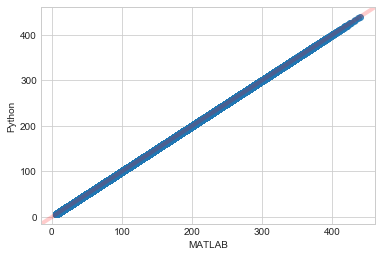

In [6]:
matlab = nib.load(op.join(mat_dir, 'fishers/fishers_ffx_statistic.nii'))
python = nib.load(op.join(res_dir, 'fishers_ffx_stat.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

0.00021610909886639042


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


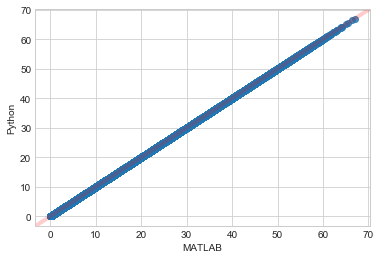

In [7]:
matlab = nib.load(op.join(mat_dir, 'fishers/fishers_ffx_minus_log10_p.nii'))
python = nib.load(op.join(res_dir, 'fishers_log_p.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

# Weighted Stouffer's

0.004258480082684577


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


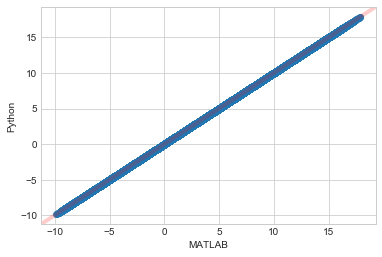

In [8]:
matlab = nib.load(op.join(mat_dir, 'weighted_stouffers/weightedz_ffx_statistic.nii'))
python = nib.load(op.join(res_dir, 'stouffers_weighted_ffx_stat.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

0.008868091149863843


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


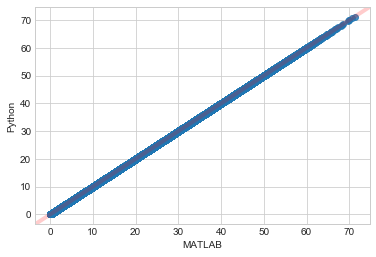

In [9]:
matlab = nib.load(op.join(mat_dir, 'weighted_stouffers/weightedz_ffx_minus_log10_p.nii'))
python = nib.load(op.join(res_dir, 'stouffers_weighted_log_p.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

# Stouffer's FFX

0.00023813532807336822


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


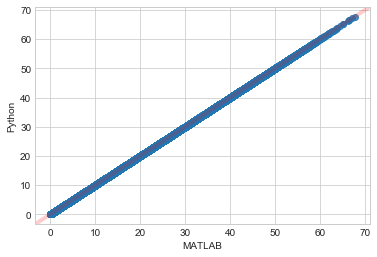

In [10]:
matlab = nib.load(op.join(mat_dir, 'stouffers_ffx/stouffers_ffx_minus_log10_p.nii'))
python = nib.load(op.join(res_dir, 'stouffers_ffx_log_p.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

# Stouffer's RFX

7.463682891062094e-05


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


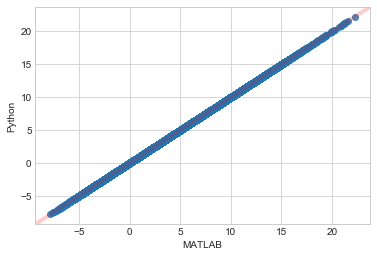

In [11]:
matlab = nib.load(op.join(mat_dir, 'stouffers_rfx/spmT_0001.img'))
python = nib.load(op.join(res_dir, 'stouffers_rfx_t.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

5.990968178031958e-05


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


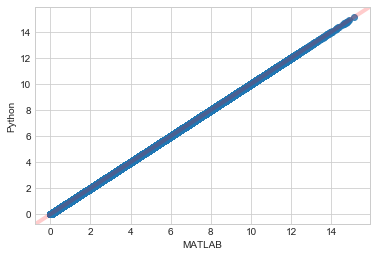

In [12]:
matlab = nib.load(op.join(mat_dir, 'stouffers_rfx/stouffers_rfx_minus_log10_p.nii'))
python = nib.load(op.join(res_dir, 'stouffers_rfx_log_p.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

# FFX GLM

0.00216147157445512


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


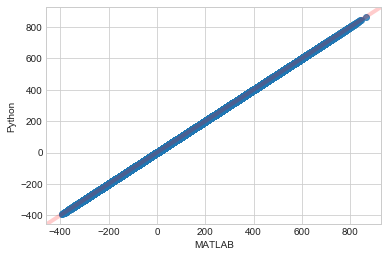

In [13]:
matlab = nib.load(op.join(mat_dir, 'ffx_glm/mega_ffx_statistic.nii'))
python = nib.load(op.join(res_dir, 'ffx_glm_ffx_stat.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()

323.30627303925377


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


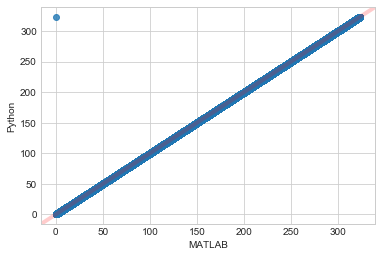

In [14]:
# there's one wonky voxel, but other than that it's all good
matlab = nib.load(op.join(mat_dir, 'ffx_glm/mega_ffx_ffx_minus_log10_p.nii'))
python = nib.load(op.join(res_dir, 'ffx_glm_log_p.nii.gz'))
matlab = apply_mask(matlab, mask_img)
python = apply_mask(python, mask_img)
fig, ax = plt.subplots()
sns.regplot(matlab, python, fit_reg=False, ax=ax)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [xmin, xmax], color='red',
        linewidth=4, alpha=0.2)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.set_xlabel('MATLAB')
ax.set_ylabel('Python')
print(euclidean(matlab, python))
fig.show()